# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [3]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в этой функции.
Вычислите градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)


In [4]:
def sqr(x):
    return x*x, 2*x

check_gradient(sqr, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [51]:
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [52]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, 1)

5.006760443547122

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [53]:
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))

Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [5]:

# Test batch_size = 1
batch_size = 1
predictions = np.zeros((batch_size, 3))
target_index = np.ones(batch_size, np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
batch_size = 3
predictions = np.zeros((batch_size, 3))
target_index = np.ones(batch_size, np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

Gradient check passed!
Gradient check passed!


True

### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [6]:
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [7]:
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [77]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

Epoch 0, loss: 5.799605
Epoch 1, loss: 5.732020
Epoch 2, loss: 5.712018
Epoch 3, loss: 5.705700
Epoch 4, loss: 5.705593
Epoch 5, loss: 5.701549
Epoch 6, loss: 5.704788
Epoch 7, loss: 5.704310
Epoch 8, loss: 5.703230
Epoch 9, loss: 5.706512


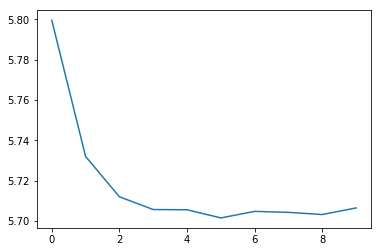

In [78]:
# let's look at the loss history!
plt.plot(loss_history)

In [107]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)

accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.096
Epoch 0, loss: 5.703453
Epoch 1, loss: 5.703837
Epoch 2, loss: 5.704292
Epoch 3, loss: 5.704409
Epoch 4, loss: 5.703372
Epoch 5, loss: 5.704944
Epoch 6, loss: 5.703798
Epoch 7, loss: 5.705386
Epoch 8, loss: 5.702290
Epoch 9, loss: 5.702757
Epoch 10, loss: 5.703531
Epoch 11, loss: 5.704744
Epoch 12, loss: 5.705047
Epoch 13, loss: 5.703653
Epoch 14, loss: 5.704504
Epoch 15, loss: 5.703711
Epoch 16, loss: 5.704085
Epoch 17, loss: 5.703681
Epoch 18, loss: 5.703794
Epoch 19, loss: 5.704299
Epoch 20, loss: 5.704403
Epoch 21, loss: 5.704039
Epoch 22, loss: 5.704629
Epoch 23, loss: 5.705085
Epoch 24, loss: 5.703863
Epoch 25, loss: 5.703935
Epoch 26, loss: 5.703871
Epoch 27, loss: 5.704571
Epoch 28, loss: 5.704075
Epoch 29, loss: 5.702635
Epoch 30, loss: 5.703874
Epoch 31, loss: 5.704216
Epoch 32, loss: 5.704129
Epoch 33, loss: 5.704455
Epoch 34, loss: 5.703260
Epoch 35, loss: 5.706780
Epoch 36, loss: 5.710661
Epoch 37, loss: 5.704124
Epoch 38, loss: 5.703353
Epoch 39, loss: 5.

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [133]:
num_epochs = 200
batch_size = 300

learning_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
reg_strengths = [1e-3, 1e-2, 1e-4, 1e-5, 1e-6, 1e-7]
best_val_accuracy = 0
for learning_rate in learning_rates:
    for reg_strength in reg_strengths:
        classifier.fit(train_X, train_y, batch_size, learning_rate, reg_strength, num_epochs)
        pred = classifier.predict(val_X)
        accuracy = multiclass_accuracy(pred, val_y)
        print('Accuracy %f reg_strength %f learning rate %f' % (accuracy, reg_strength, learning_rate))
        print('Accuracy %f reg_strength %f learning rate %f' % (accuracy, reg_strength, learning_rate), file=open("accuracy.txt", "a"))
        best_val_accuracy = max(best_val_accuracy, accuracy)
        
best_classifier = None
# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially

print('best validation accuracy achieved: %f' % best_val_accuracy)

Epoch 0, loss: 12.569188
Epoch 1, loss: 12.423534
Epoch 2, loss: 12.396902
Epoch 3, loss: 12.392295
Epoch 4, loss: 12.330444
Epoch 5, loss: 12.274224
Epoch 6, loss: 12.561518
Epoch 7, loss: 12.610684
Epoch 8, loss: 12.013969
Epoch 9, loss: 12.470542
Epoch 10, loss: 12.303619
Epoch 11, loss: 11.986392
Epoch 12, loss: 12.145570
Epoch 13, loss: 12.048929
Epoch 14, loss: 12.013986
Epoch 15, loss: 12.160893
Epoch 16, loss: 12.047181
Epoch 17, loss: 11.990052
Epoch 18, loss: 12.154592
Epoch 19, loss: 11.900556
Epoch 20, loss: 11.910932
Epoch 21, loss: 11.808849
Epoch 22, loss: 11.912198
Epoch 23, loss: 11.821394
Epoch 24, loss: 11.891484
Epoch 25, loss: 11.724846
Epoch 26, loss: 11.819172
Epoch 27, loss: 11.723387
Epoch 28, loss: 11.634832
Epoch 29, loss: 11.648213
Epoch 30, loss: 11.881111
Epoch 31, loss: 11.658036
Epoch 32, loss: 11.584353
Epoch 33, loss: 11.621564
Epoch 34, loss: 11.532874
Epoch 35, loss: 11.605737
Epoch 36, loss: 11.632218
Epoch 37, loss: 11.493145
Epoch 38, loss: 11.395

Epoch 116, loss: 6.371072
Epoch 117, loss: 6.372719
Epoch 118, loss: 6.324034
Epoch 119, loss: 6.389421
Epoch 120, loss: 6.307348
Epoch 121, loss: 6.241646
Epoch 122, loss: 6.337424
Epoch 123, loss: 6.359343
Epoch 124, loss: 6.330132
Epoch 125, loss: 6.254492
Epoch 126, loss: 6.373095
Epoch 127, loss: 6.317742
Epoch 128, loss: 6.526491
Epoch 129, loss: 6.473575
Epoch 130, loss: 6.557405
Epoch 131, loss: 6.577379
Epoch 132, loss: 6.426494
Epoch 133, loss: 6.245542
Epoch 134, loss: 6.303703
Epoch 135, loss: 6.351487
Epoch 136, loss: 6.412547
Epoch 137, loss: 6.352183
Epoch 138, loss: 6.337229
Epoch 139, loss: 6.417172
Epoch 140, loss: 6.303552
Epoch 141, loss: 6.261539
Epoch 142, loss: 6.341871
Epoch 143, loss: 6.278350
Epoch 144, loss: 6.326646
Epoch 145, loss: 6.297275
Epoch 146, loss: 6.531839
Epoch 147, loss: 6.269065
Epoch 148, loss: 6.374126
Epoch 149, loss: 6.353026
Epoch 150, loss: 6.331226
Epoch 151, loss: 6.128177
Epoch 152, loss: 6.309626
Epoch 153, loss: 6.287288
Epoch 154, l

Epoch 33, loss: 6.290375
Epoch 34, loss: 6.254710
Epoch 35, loss: 6.228067
Epoch 36, loss: 6.263697
Epoch 37, loss: 6.157682
Epoch 38, loss: 6.227999
Epoch 39, loss: 6.510188
Epoch 40, loss: 6.242987
Epoch 41, loss: 6.230702
Epoch 42, loss: 6.191814
Epoch 43, loss: 6.233227
Epoch 44, loss: 6.174457
Epoch 45, loss: 6.292219
Epoch 46, loss: 6.325482
Epoch 47, loss: 5.964322
Epoch 48, loss: 6.119371
Epoch 49, loss: 6.300345
Epoch 50, loss: 6.251841
Epoch 51, loss: 6.350690
Epoch 52, loss: 6.255345
Epoch 53, loss: 6.310812
Epoch 54, loss: 6.244507
Epoch 55, loss: 6.375128
Epoch 56, loss: 6.190214
Epoch 57, loss: 6.328957
Epoch 58, loss: 6.263956
Epoch 59, loss: 6.274074
Epoch 60, loss: 6.333571
Epoch 61, loss: 6.268597
Epoch 62, loss: 6.247969
Epoch 63, loss: 6.346555
Epoch 64, loss: 6.227229
Epoch 65, loss: 6.320258
Epoch 66, loss: 6.308612
Epoch 67, loss: 6.290996
Epoch 68, loss: 6.171774
Epoch 69, loss: 6.318347
Epoch 70, loss: 6.176628
Epoch 71, loss: 6.321846
Epoch 72, loss: 6.234553


Epoch 153, loss: 6.443784
Epoch 154, loss: 6.221725
Epoch 155, loss: 6.273911
Epoch 156, loss: 6.411357
Epoch 157, loss: 6.311488
Epoch 158, loss: 6.271147
Epoch 159, loss: 6.077221
Epoch 160, loss: 6.189106
Epoch 161, loss: 6.274220
Epoch 162, loss: 6.197801
Epoch 163, loss: 6.365220
Epoch 164, loss: 6.329088
Epoch 165, loss: 6.183521
Epoch 166, loss: 6.389986
Epoch 167, loss: 6.254013
Epoch 168, loss: 6.142683
Epoch 169, loss: 6.283197
Epoch 170, loss: 6.235509
Epoch 171, loss: 6.258275
Epoch 172, loss: 6.246601
Epoch 173, loss: 6.083723
Epoch 174, loss: 6.414075
Epoch 175, loss: 6.371056
Epoch 176, loss: 6.459997
Epoch 177, loss: 6.357812
Epoch 178, loss: 6.271352
Epoch 179, loss: 6.445246
Epoch 180, loss: 6.196931
Epoch 181, loss: 6.403667
Epoch 182, loss: 6.258564
Epoch 183, loss: 6.076629
Epoch 184, loss: 6.367794
Epoch 185, loss: 6.144476
Epoch 186, loss: 6.459552
Epoch 187, loss: 6.222939
Epoch 188, loss: 6.130114
Epoch 189, loss: 6.416351
Epoch 190, loss: 6.268790
Epoch 191, l

Epoch 68, loss: 13.070033
Epoch 69, loss: 12.895076
Epoch 70, loss: 12.938817
Epoch 71, loss: 12.938936
Epoch 72, loss: 13.032277
Epoch 73, loss: 13.047346
Epoch 74, loss: 12.946792
Epoch 75, loss: 12.910841
Epoch 76, loss: 12.985112
Epoch 77, loss: 12.930451
Epoch 78, loss: 13.047535
Epoch 79, loss: 12.970762
Epoch 80, loss: 13.076034
Epoch 81, loss: 12.971616
Epoch 82, loss: 12.952810
Epoch 83, loss: 12.940249
Epoch 84, loss: 12.792667
Epoch 85, loss: 13.000061
Epoch 86, loss: 12.864083
Epoch 87, loss: 12.884540
Epoch 88, loss: 12.932137
Epoch 89, loss: 12.753496
Epoch 90, loss: 12.980980
Epoch 91, loss: 12.874416
Epoch 92, loss: 12.904376
Epoch 93, loss: 12.749702
Epoch 94, loss: 12.875006
Epoch 95, loss: 12.773112
Epoch 96, loss: 12.949631
Epoch 97, loss: 12.838402
Epoch 98, loss: 12.932639
Epoch 99, loss: 13.066815
Epoch 100, loss: 12.933869
Epoch 101, loss: 12.866163
Epoch 102, loss: 12.679406
Epoch 103, loss: 12.875761
Epoch 104, loss: 13.012736
Epoch 105, loss: 12.923120
Epoch 

Epoch 175, loss: 25.330223
Epoch 176, loss: 25.223933
Epoch 177, loss: 25.117424
Epoch 178, loss: 24.942924
Epoch 179, loss: 24.792689
Epoch 180, loss: 24.675285
Epoch 181, loss: 24.553272
Epoch 182, loss: 24.444085
Epoch 183, loss: 24.369872
Epoch 184, loss: 24.275601
Epoch 185, loss: 24.053656
Epoch 186, loss: 23.979928
Epoch 187, loss: 23.844108
Epoch 188, loss: 23.715849
Epoch 189, loss: 23.583878
Epoch 190, loss: 23.451588
Epoch 191, loss: 23.389481
Epoch 192, loss: 23.205716
Epoch 193, loss: 23.179822
Epoch 194, loss: 23.037296
Epoch 195, loss: 22.919254
Epoch 196, loss: 22.736948
Epoch 197, loss: 22.699752
Epoch 198, loss: 22.599930
Epoch 199, loss: 22.517353
Accuracy 0.064000 reg_strength 0.010000 learning rate 0.010000
Epoch 0, loss: 6.373137
Epoch 1, loss: 6.363406
Epoch 2, loss: 6.391543
Epoch 3, loss: 6.463989
Epoch 4, loss: 6.341024
Epoch 5, loss: 6.408231
Epoch 6, loss: 6.390458
Epoch 7, loss: 6.378393
Epoch 8, loss: 6.381222
Epoch 9, loss: 6.353240
Epoch 10, loss: 6.3741

Epoch 93, loss: 6.209526
Epoch 94, loss: 6.241404
Epoch 95, loss: 6.259356
Epoch 96, loss: 6.217034
Epoch 97, loss: 6.325993
Epoch 98, loss: 6.220345
Epoch 99, loss: 6.206691
Epoch 100, loss: 6.292844
Epoch 101, loss: 6.206142
Epoch 102, loss: 6.285852
Epoch 103, loss: 6.241831
Epoch 104, loss: 6.262786
Epoch 105, loss: 6.219536
Epoch 106, loss: 6.273102
Epoch 107, loss: 6.293603
Epoch 108, loss: 6.252857
Epoch 109, loss: 6.260254
Epoch 110, loss: 6.189628
Epoch 111, loss: 6.251298
Epoch 112, loss: 6.241378
Epoch 113, loss: 6.242462
Epoch 114, loss: 6.296055
Epoch 115, loss: 6.299028
Epoch 116, loss: 6.259605
Epoch 117, loss: 6.210708
Epoch 118, loss: 6.358225
Epoch 119, loss: 6.159034
Epoch 120, loss: 6.217253
Epoch 121, loss: 6.340914
Epoch 122, loss: 6.197122
Epoch 123, loss: 6.301922
Epoch 124, loss: 6.293571
Epoch 125, loss: 6.136702
Epoch 126, loss: 6.230471
Epoch 127, loss: 6.175217
Epoch 128, loss: 6.209853
Epoch 129, loss: 6.247188
Epoch 130, loss: 6.260799
Epoch 131, loss: 6.

Epoch 9, loss: 6.248664
Epoch 10, loss: 6.164613
Epoch 11, loss: 6.375166
Epoch 12, loss: 6.135382
Epoch 13, loss: 6.256296
Epoch 14, loss: 6.188858
Epoch 15, loss: 6.287892
Epoch 16, loss: 6.334763
Epoch 17, loss: 6.171141
Epoch 18, loss: 6.210650
Epoch 19, loss: 6.238459
Epoch 20, loss: 6.203341
Epoch 21, loss: 6.320321
Epoch 22, loss: 6.214652
Epoch 23, loss: 6.162822
Epoch 24, loss: 6.171991
Epoch 25, loss: 6.320283
Epoch 26, loss: 6.495765
Epoch 27, loss: 6.279581
Epoch 28, loss: 6.157856
Epoch 29, loss: 6.009918
Epoch 30, loss: 6.166999
Epoch 31, loss: 6.229894
Epoch 32, loss: 6.197335
Epoch 33, loss: 6.227949
Epoch 34, loss: 6.297312
Epoch 35, loss: 6.222037
Epoch 36, loss: 6.232982
Epoch 37, loss: 6.191222
Epoch 38, loss: 6.199671
Epoch 39, loss: 6.271420
Epoch 40, loss: 6.241887
Epoch 41, loss: 6.189501
Epoch 42, loss: 6.359655
Epoch 43, loss: 6.154760
Epoch 44, loss: 6.192273
Epoch 45, loss: 6.294776
Epoch 46, loss: 6.221828
Epoch 47, loss: 6.211711
Epoch 48, loss: 6.217493
E

Epoch 130, loss: 8.509419
Epoch 131, loss: 8.569679
Epoch 132, loss: 8.572948
Epoch 133, loss: 8.467547
Epoch 134, loss: 8.505287
Epoch 135, loss: 8.546895
Epoch 136, loss: 8.517148
Epoch 137, loss: 8.479330
Epoch 138, loss: 8.562273
Epoch 139, loss: 8.458210
Epoch 140, loss: 8.500031
Epoch 141, loss: 8.512857
Epoch 142, loss: 8.623885
Epoch 143, loss: 8.566630
Epoch 144, loss: 8.625080
Epoch 145, loss: 8.513370
Epoch 146, loss: 8.493410
Epoch 147, loss: 8.548961
Epoch 148, loss: 8.572535
Epoch 149, loss: 8.485253
Epoch 150, loss: 8.506776
Epoch 151, loss: 8.535418
Epoch 152, loss: 8.490986
Epoch 153, loss: 8.492249
Epoch 154, loss: 8.555821
Epoch 155, loss: 8.611120
Epoch 156, loss: 8.603120
Epoch 157, loss: 8.514118
Epoch 158, loss: 8.590399
Epoch 159, loss: 8.526735
Epoch 160, loss: 8.390899
Epoch 161, loss: 8.544350
Epoch 162, loss: 8.475676
Epoch 163, loss: 8.552336
Epoch 164, loss: 8.541795
Epoch 165, loss: 8.548178
Epoch 166, loss: 8.563807
Epoch 167, loss: 8.569470
Epoch 168, l

Epoch 39, loss: 6.452091
Epoch 40, loss: 6.382838
Epoch 41, loss: 6.369523
Epoch 42, loss: 6.470763
Epoch 43, loss: 6.357516
Epoch 44, loss: 6.486879
Epoch 45, loss: 6.413201
Epoch 46, loss: 6.404079
Epoch 47, loss: 6.436567
Epoch 48, loss: 6.407751
Epoch 49, loss: 6.451972
Epoch 50, loss: 6.448514
Epoch 51, loss: 6.457840
Epoch 52, loss: 6.362662
Epoch 53, loss: 6.451237
Epoch 54, loss: 6.373004
Epoch 55, loss: 6.434667
Epoch 56, loss: 6.421887
Epoch 57, loss: 6.436075
Epoch 58, loss: 6.469943
Epoch 59, loss: 6.420647
Epoch 60, loss: 6.387809
Epoch 61, loss: 6.437567
Epoch 62, loss: 6.434513
Epoch 63, loss: 6.464906
Epoch 64, loss: 6.454442
Epoch 65, loss: 6.482929
Epoch 66, loss: 6.450188
Epoch 67, loss: 6.416982
Epoch 68, loss: 6.459661
Epoch 69, loss: 6.379220
Epoch 70, loss: 6.373568
Epoch 71, loss: 6.442233
Epoch 72, loss: 6.376602
Epoch 73, loss: 6.442231
Epoch 74, loss: 6.454310
Epoch 75, loss: 6.431260
Epoch 76, loss: 6.462094
Epoch 77, loss: 6.389053
Epoch 78, loss: 6.458074


Epoch 159, loss: 6.210001
Epoch 160, loss: 6.155426
Epoch 161, loss: 6.243255
Epoch 162, loss: 6.283939
Epoch 163, loss: 6.207754
Epoch 164, loss: 6.226265
Epoch 165, loss: 6.215531
Epoch 166, loss: 6.194910
Epoch 167, loss: 6.239688
Epoch 168, loss: 6.318028
Epoch 169, loss: 6.241352
Epoch 170, loss: 6.232716
Epoch 171, loss: 6.261615
Epoch 172, loss: 6.237135
Epoch 173, loss: 6.231445
Epoch 174, loss: 6.189202
Epoch 175, loss: 6.288944
Epoch 176, loss: 6.224615
Epoch 177, loss: 6.230437
Epoch 178, loss: 6.243996
Epoch 179, loss: 6.266864
Epoch 180, loss: 6.232137
Epoch 181, loss: 6.225926
Epoch 182, loss: 6.221029
Epoch 183, loss: 6.157251
Epoch 184, loss: 6.256057
Epoch 185, loss: 6.239542
Epoch 186, loss: 6.254677
Epoch 187, loss: 6.292121
Epoch 188, loss: 6.238825
Epoch 189, loss: 6.221479
Epoch 190, loss: 6.195734
Epoch 191, loss: 6.296756
Epoch 192, loss: 6.231080
Epoch 193, loss: 6.171261
Epoch 194, loss: 6.307701
Epoch 195, loss: 6.240954
Epoch 196, loss: 6.228117
Epoch 197, l

Epoch 77, loss: 6.251033
Epoch 78, loss: 6.216376
Epoch 79, loss: 6.190371
Epoch 80, loss: 6.238574
Epoch 81, loss: 6.187791
Epoch 82, loss: 6.196925
Epoch 83, loss: 6.242430
Epoch 84, loss: 6.261484
Epoch 85, loss: 6.221041
Epoch 86, loss: 6.188430
Epoch 87, loss: 6.165239
Epoch 88, loss: 6.249813
Epoch 89, loss: 6.242132
Epoch 90, loss: 6.234304
Epoch 91, loss: 6.191690
Epoch 92, loss: 6.239279
Epoch 93, loss: 6.232968
Epoch 94, loss: 6.221294
Epoch 95, loss: 6.199356
Epoch 96, loss: 6.205855
Epoch 97, loss: 6.244945
Epoch 98, loss: 6.229579
Epoch 99, loss: 6.243702
Epoch 100, loss: 6.227322
Epoch 101, loss: 6.237048
Epoch 102, loss: 6.225519
Epoch 103, loss: 6.213276
Epoch 104, loss: 6.217747
Epoch 105, loss: 6.171963
Epoch 106, loss: 6.225308
Epoch 107, loss: 6.200913
Epoch 108, loss: 6.176325
Epoch 109, loss: 6.228400
Epoch 110, loss: 6.193563
Epoch 111, loss: 6.195386
Epoch 112, loss: 6.265085
Epoch 113, loss: 6.261194
Epoch 114, loss: 6.194601
Epoch 115, loss: 6.258479
Epoch 116

Epoch 195, loss: 8.323679
Epoch 196, loss: 8.320971
Epoch 197, loss: 8.338969
Epoch 198, loss: 8.291480
Epoch 199, loss: 8.301034
Accuracy 0.066000 reg_strength 0.001000 learning rate 0.000100
Epoch 0, loss: 27.039828
Epoch 1, loss: 27.069102
Epoch 2, loss: 27.106294
Epoch 3, loss: 27.083795
Epoch 4, loss: 27.036790
Epoch 5, loss: 27.040143
Epoch 6, loss: 27.073477
Epoch 7, loss: 27.059513
Epoch 8, loss: 27.044373
Epoch 9, loss: 27.087278
Epoch 10, loss: 27.042615
Epoch 11, loss: 27.040777
Epoch 12, loss: 27.038091
Epoch 13, loss: 27.037071
Epoch 14, loss: 27.021337
Epoch 15, loss: 27.092049
Epoch 16, loss: 27.087458
Epoch 17, loss: 27.105539
Epoch 18, loss: 27.110570
Epoch 19, loss: 27.050177
Epoch 20, loss: 27.002337
Epoch 21, loss: 27.024916
Epoch 22, loss: 27.059319
Epoch 23, loss: 27.105000
Epoch 24, loss: 27.020342
Epoch 25, loss: 27.020404
Epoch 26, loss: 27.045044
Epoch 27, loss: 27.033771
Epoch 28, loss: 27.052602
Epoch 29, loss: 27.001735
Epoch 30, loss: 27.046645
Epoch 31, l

Epoch 107, loss: 6.431379
Epoch 108, loss: 6.407371
Epoch 109, loss: 6.478321
Epoch 110, loss: 6.488268
Epoch 111, loss: 6.402965
Epoch 112, loss: 6.435226
Epoch 113, loss: 6.414429
Epoch 114, loss: 6.387777
Epoch 115, loss: 6.428835
Epoch 116, loss: 6.422007
Epoch 117, loss: 6.487472
Epoch 118, loss: 6.451231
Epoch 119, loss: 6.404324
Epoch 120, loss: 6.421657
Epoch 121, loss: 6.394200
Epoch 122, loss: 6.402543
Epoch 123, loss: 6.442285
Epoch 124, loss: 6.472733
Epoch 125, loss: 6.450993
Epoch 126, loss: 6.429596
Epoch 127, loss: 6.483055
Epoch 128, loss: 6.430713
Epoch 129, loss: 6.422294
Epoch 130, loss: 6.387220
Epoch 131, loss: 6.456143
Epoch 132, loss: 6.426879
Epoch 133, loss: 6.439215
Epoch 134, loss: 6.423650
Epoch 135, loss: 6.476428
Epoch 136, loss: 6.468983
Epoch 137, loss: 6.407335
Epoch 138, loss: 6.425886
Epoch 139, loss: 6.447342
Epoch 140, loss: 6.466983
Epoch 141, loss: 6.402829
Epoch 142, loss: 6.363099
Epoch 143, loss: 6.396895
Epoch 144, loss: 6.437489
Epoch 145, l

Epoch 23, loss: 6.201850
Epoch 24, loss: 6.228341
Epoch 25, loss: 6.177392
Epoch 26, loss: 6.201914
Epoch 27, loss: 6.185570
Epoch 28, loss: 6.262040
Epoch 29, loss: 6.219912
Epoch 30, loss: 6.258357
Epoch 31, loss: 6.222896
Epoch 32, loss: 6.206887
Epoch 33, loss: 6.222669
Epoch 34, loss: 6.234667
Epoch 35, loss: 6.209557
Epoch 36, loss: 6.203965
Epoch 37, loss: 6.253757
Epoch 38, loss: 6.232535
Epoch 39, loss: 6.219957
Epoch 40, loss: 6.211601
Epoch 41, loss: 6.178755
Epoch 42, loss: 6.287009
Epoch 43, loss: 6.199588
Epoch 44, loss: 6.261653
Epoch 45, loss: 6.228102
Epoch 46, loss: 6.276515
Epoch 47, loss: 6.233830
Epoch 48, loss: 6.170211
Epoch 49, loss: 6.261584
Epoch 50, loss: 6.280724
Epoch 51, loss: 6.215686
Epoch 52, loss: 6.258404
Epoch 53, loss: 6.265529
Epoch 54, loss: 6.190285
Epoch 55, loss: 6.233181
Epoch 56, loss: 6.261325
Epoch 57, loss: 6.173837
Epoch 58, loss: 6.212701
Epoch 59, loss: 6.239664
Epoch 60, loss: 6.201314
Epoch 61, loss: 6.253590
Epoch 62, loss: 6.221838


Epoch 143, loss: 6.289780
Epoch 144, loss: 6.184320
Epoch 145, loss: 6.166327
Epoch 146, loss: 6.217165
Epoch 147, loss: 6.202099
Epoch 148, loss: 6.264609
Epoch 149, loss: 6.228522
Epoch 150, loss: 6.186337
Epoch 151, loss: 6.236982
Epoch 152, loss: 6.191759
Epoch 153, loss: 6.140340
Epoch 154, loss: 6.193946
Epoch 155, loss: 6.240728
Epoch 156, loss: 6.235372
Epoch 157, loss: 6.277020
Epoch 158, loss: 6.213486
Epoch 159, loss: 6.227545
Epoch 160, loss: 6.194881
Epoch 161, loss: 6.224032
Epoch 162, loss: 6.297939
Epoch 163, loss: 6.187846
Epoch 164, loss: 6.230339
Epoch 165, loss: 6.197658
Epoch 166, loss: 6.212718
Epoch 167, loss: 6.194853
Epoch 168, loss: 6.219289
Epoch 169, loss: 6.203496
Epoch 170, loss: 6.174174
Epoch 171, loss: 6.238230
Epoch 172, loss: 6.199378
Epoch 173, loss: 6.227869
Epoch 174, loss: 6.198465
Epoch 175, loss: 6.222275
Epoch 176, loss: 6.251714
Epoch 177, loss: 6.190409
Epoch 178, loss: 6.234684
Epoch 179, loss: 6.209700
Epoch 180, loss: 6.146205
Epoch 181, l

Epoch 58, loss: 26.849092
Epoch 59, loss: 26.849973
Epoch 60, loss: 26.837537
Epoch 61, loss: 26.818745
Epoch 62, loss: 26.828632
Epoch 63, loss: 26.826070
Epoch 64, loss: 26.840618
Epoch 65, loss: 26.901927
Epoch 66, loss: 26.891684
Epoch 67, loss: 26.831688
Epoch 68, loss: 26.825180
Epoch 69, loss: 26.927158
Epoch 70, loss: 26.840607
Epoch 71, loss: 26.779978
Epoch 72, loss: 26.872171
Epoch 73, loss: 26.807598
Epoch 74, loss: 26.833977
Epoch 75, loss: 26.859098
Epoch 76, loss: 26.872067
Epoch 77, loss: 26.811982
Epoch 78, loss: 26.862779
Epoch 79, loss: 26.833457
Epoch 80, loss: 26.814653
Epoch 81, loss: 26.831111
Epoch 82, loss: 26.830163
Epoch 83, loss: 26.949627
Epoch 84, loss: 26.890928
Epoch 85, loss: 26.850447
Epoch 86, loss: 26.815823
Epoch 87, loss: 26.835472
Epoch 88, loss: 26.776119
Epoch 89, loss: 26.808517
Epoch 90, loss: 26.810788
Epoch 91, loss: 26.915261
Epoch 92, loss: 26.803700
Epoch 93, loss: 26.851077
Epoch 94, loss: 26.849411
Epoch 95, loss: 26.887827
Epoch 96, lo

Epoch 172, loss: 6.410729
Epoch 173, loss: 6.428822
Epoch 174, loss: 6.328767
Epoch 175, loss: 6.412814
Epoch 176, loss: 6.432582
Epoch 177, loss: 6.488482
Epoch 178, loss: 6.391857
Epoch 179, loss: 6.458497
Epoch 180, loss: 6.353940
Epoch 181, loss: 6.424434
Epoch 182, loss: 6.438327
Epoch 183, loss: 6.448154
Epoch 184, loss: 6.438447
Epoch 185, loss: 6.435861
Epoch 186, loss: 6.386292
Epoch 187, loss: 6.365426
Epoch 188, loss: 6.413179
Epoch 189, loss: 6.415265
Epoch 190, loss: 6.393073
Epoch 191, loss: 6.429616
Epoch 192, loss: 6.415644
Epoch 193, loss: 6.416474
Epoch 194, loss: 6.407424
Epoch 195, loss: 6.387063
Epoch 196, loss: 6.451296
Epoch 197, loss: 6.487563
Epoch 198, loss: 6.420004
Epoch 199, loss: 6.498575
Accuracy 0.067000 reg_strength 0.000100 learning rate 0.000010
Epoch 0, loss: 6.282034
Epoch 1, loss: 6.281548
Epoch 2, loss: 6.248874
Epoch 3, loss: 6.227159
Epoch 4, loss: 6.274167
Epoch 5, loss: 6.227365
Epoch 6, loss: 6.239785
Epoch 7, loss: 6.295443
Epoch 8, loss: 6.

Epoch 91, loss: 6.149730
Epoch 92, loss: 6.196727
Epoch 93, loss: 6.218006
Epoch 94, loss: 6.217982
Epoch 95, loss: 6.233482
Epoch 96, loss: 6.261198
Epoch 97, loss: 6.197801
Epoch 98, loss: 6.258809
Epoch 99, loss: 6.200114
Epoch 100, loss: 6.203349
Epoch 101, loss: 6.200077
Epoch 102, loss: 6.205542
Epoch 103, loss: 6.284044
Epoch 104, loss: 6.217579
Epoch 105, loss: 6.255125
Epoch 106, loss: 6.183856
Epoch 107, loss: 6.200335
Epoch 108, loss: 6.238123
Epoch 109, loss: 6.258185
Epoch 110, loss: 6.194869
Epoch 111, loss: 6.162984
Epoch 112, loss: 6.282635
Epoch 113, loss: 6.234121
Epoch 114, loss: 6.291905
Epoch 115, loss: 6.206030
Epoch 116, loss: 6.234821
Epoch 117, loss: 6.317150
Epoch 118, loss: 6.213792
Epoch 119, loss: 6.235439
Epoch 120, loss: 6.172478
Epoch 121, loss: 6.194926
Epoch 122, loss: 6.266066
Epoch 123, loss: 6.233143
Epoch 124, loss: 6.300222
Epoch 125, loss: 6.282903
Epoch 126, loss: 6.266718
Epoch 127, loss: 6.215400
Epoch 128, loss: 6.212602
Epoch 129, loss: 6.24

In [145]:
best_classifier = linear_classifer.LinearSoftmaxClassifier() 
best_classifier.fit(train_X, train_y, batch_size, 1e-5, 1e-6, 200)

Epoch 0, loss: 6.217408
Epoch 1, loss: 6.214558
Epoch 2, loss: 6.213763
Epoch 3, loss: 6.213054
Epoch 4, loss: 6.215109
Epoch 5, loss: 6.212698
Epoch 6, loss: 6.214701
Epoch 7, loss: 6.215050
Epoch 8, loss: 6.215644
Epoch 9, loss: 6.215264
Epoch 10, loss: 6.212994
Epoch 11, loss: 6.214236
Epoch 12, loss: 6.215438
Epoch 13, loss: 6.214482
Epoch 14, loss: 6.213884
Epoch 15, loss: 6.216075
Epoch 16, loss: 6.214255
Epoch 17, loss: 6.215321
Epoch 18, loss: 6.214156
Epoch 19, loss: 6.215243
Epoch 20, loss: 6.214145
Epoch 21, loss: 6.213948
Epoch 22, loss: 6.216569
Epoch 23, loss: 6.214154
Epoch 24, loss: 6.214176
Epoch 25, loss: 6.214404
Epoch 26, loss: 6.214463
Epoch 27, loss: 6.213321
Epoch 28, loss: 6.215753
Epoch 29, loss: 6.216653
Epoch 30, loss: 6.215486
Epoch 31, loss: 6.215201
Epoch 32, loss: 6.214126
Epoch 33, loss: 6.215776
Epoch 34, loss: 6.215028
Epoch 35, loss: 6.215173
Epoch 36, loss: 6.213882
Epoch 37, loss: 6.213173
Epoch 38, loss: 6.213804
Epoch 39, loss: 6.214581
Epoch 40, 

[6.217408100349165,
 6.214558298801424,
 6.213763311702085,
 6.213054062174892,
 6.215109289623079,
 6.212698096086581,
 6.214700566536669,
 6.215049980607443,
 6.215643757252405,
 6.2152635260935645,
 6.212993922072619,
 6.214235587942036,
 6.21543770298931,
 6.2144819288975315,
 6.213884195864542,
 6.216074850673132,
 6.214255320638907,
 6.215320611257293,
 6.214156027424469,
 6.215243331500928,
 6.21414486967792,
 6.21394806396897,
 6.216569480934746,
 6.214153875596066,
 6.214176298575144,
 6.214404467282699,
 6.214462528951778,
 6.213321368950315,
 6.215753370117175,
 6.216652536958419,
 6.2154862937953155,
 6.2152011312050055,
 6.21412557427662,
 6.215776396769019,
 6.215027596148583,
 6.2151729059721985,
 6.213882363706408,
 6.213173254734701,
 6.213804250886286,
 6.214580735831434,
 6.2147910883068755,
 6.215125077040896,
 6.214662098761335,
 6.216186581276175,
 6.21392104247283,
 6.214882110551856,
 6.21367936894611,
 6.213315680195363,
 6.21431354882997,
 6.2145052548706525,


# Какой же точности мы добились на тестовых данных?

In [149]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))


Linear softmax classifier test set accuracy: 0.095000
